# Iceberg CASMI22

Apply the ICEBERG model to the CASMI22 data as part of paper revisions

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import yaml
import json
from collections import defaultdict
from tqdm import tqdm

from ms_pred import common
from ms_pred.common import plot_utils
import ms_pred.magma.fragmentation as fe
from ms_pred.common.plot_utils import *
from ms_pred.dag_pred import joint_model


from rdkit import Chem
from rdkit import DataStructs
from rdkit.Chem import AllChem
from rdkit.Chem import Draw

import pickle

# import networkx as nx
# from networkx.drawing.nx_pydot import graphviz_layout
# import pydot

set_style()


%load_ext autoreload
%autoreload 2

/mnt/home/samlg/miniforge-pypy3/envs/ms-gen-pred/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-01-08 08:12:11,276	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-01-08 08:12:11,462	INFO util.py:159 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


In [2]:
def single_form_from_smi(smi: str): 
    """Compute single formula + inchi key from a smiles string"""
    try:
        mol = Chem.MolFromSmiles(smi)

        if mol is not None:
            form = common.uncharged_formula(mol)

            # first remove stereochemistry
            smi = Chem.MolToSmiles(mol, isomericSmiles=False)
            inchi_key = Chem.MolToInchiKey(Chem.MolFromSmiles(smi))

            return form, (smi, inchi_key)
        else:
            return "", ("", "")
    except:
        return "", ("", "")

def compute_tanimoto(smiles1, smiles2):
    # Convert the SMILES strings to RDKit Mol objects
    mol1 = Chem.MolFromSmiles(smiles1)
    mol2 = Chem.MolFromSmiles(smiles2)

    # Generate fingerprints for each molecule
    fp1 = AllChem.GetMorganFingerprintAsBitVect(mol1, 2, nBits=2048)
    fp2 = AllChem.GetMorganFingerprintAsBitVect(mol2, 2, nBits=2048)
   
    # Get rdkit fingerprints
    # fp1 = Chem.RDKFingerprint(mol1, fpSize=2048)
    # fp2 = Chem.RDKFingerprint(mol2, fpSize=2048)


    # Compute the Tanimoto similarity between the fingerprints
    similarity = DataStructs.TanimotoSimilarity(fp1, fp2)

    return similarity

## Pre-process and get stats on casmi dataset

In [4]:
!mkdir -p ../data/spec_datasets/casmi22/
!wget https://zenodo.org/record/8151490/files/casmi22.zip
!unzip casmi22.zip
!mv casmi22 ../data/spec_datasets/casmi22/orig_data/
!rm casmi22.zip

--2023-12-24 13:12:16--  https://zenodo.org/record/8151490/files/casmi22.zip
Resolving zenodo.org (zenodo.org)... 188.184.103.159, 188.184.98.238, 188.185.79.172, ...
Connecting to zenodo.org (zenodo.org)|188.184.103.159|:443... connected.
HTTP request sent, awaiting response... 301 MOVED PERMANENTLY
Location: /records/8151490/files/casmi22.zip [following]
--2023-12-24 13:12:16--  https://zenodo.org/records/8151490/files/casmi22.zip
Reusing existing connection to zenodo.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 922912 (901K) [application/octet-stream]
Saving to: ‘casmi22.zip’

casmi22.zip         100%[===================>] 901.28K  1.66MB/s    in 0.5s    

2023-12-24 13:12:17 (1.66 MB/s) - ‘casmi22.zip’ saved [922912/922912]

Archive:  casmi22.zip
   creating: casmi22/
  inflating: casmi22/CASMI_labels.tsv  
  inflating: casmi22/CASMI.mgf       
  inflating: casmi22/CASMI_2022_key_processed.csv  
  inflating: casmi22/CASMI_processed.mgf  
  inflating: casmi22/CASM

In [82]:
# data folder
data_folder = Path(f"../data/spec_datasets/casmi22")
mgf_raw = data_folder / f"orig_data/CASMI_processed.mgf"
casmi_labels = data_folder / f"orig_data/CASMI_labels.tsv"
res_folder = Path(f"../results/casmi22_results/")
res_folder.mkdir(exist_ok=True)

In [84]:
labels_df = pd.read_csv(casmi_labels, sep="\t")

# Apply common standardize adduct to labels_df
standardized_adduct = labels_df["ionization"].apply(common.standardize_adduct)
labels_df['old_ion'] = labels_df['ionization']
labels_df['ionization'] = standardized_adduct
labels_df['formula'] = [single_form_from_smi(i)[0]  for i in labels_df['smiles'].values]

labels_df['inchikey'] = [single_form_from_smi(i)[1][1]  for i in labels_df['smiles'].values]
# display(labels_df['formula'][0])
print(labels_df.shape)
mass_mask = [common.mass_from_smi(i) < 1500 for i in labels_df['smiles']]

# Get the filtered example and print it
print(labels_df[~np.array(mass_mask)])


labels_df = labels_df[mass_mask]
print(labels_df.shape)

# Print all examples where they differ:
neq = labels_df[labels_df["ionization"] != labels_df["old_ion"]]
# Show the spec num, formula, old ion, and new ion
display(neq[["spec", "formula", "ionization", "old_ion"]][:5])

test_set = labels_df#[:10]
feat_to_ion = dict(labels_df[["spec", "ionization"]].values)
feat_to_ion_mass = {str(k): common.ion2mass[v] for k,v in feat_to_ion.items()}

(304, 9)
     dataset  spec      name        formula ionization  \
106  casmi22   202  Priority  C35H44I6N6O15     [M+H]+   

                                                smiles  \
106  CC(=O)N(CC(CN(C1=C(C(=C(C(=C1I)C(=O)NCC(CO)O)I...   

                        inchikey       instrument old_ion  
106  NBQNWMBBSKPBAY-UHFFFAOYSA-N  Orbitrap (LCMS)  [M+H]+  
(303, 9)


,spec,formula,ionization,old_ion
3,6,C54H84O22,[M+H3N+H]+,[M+NH4]+
10,18,C42H76O20,[M+H3N+H]+,[M+NH4]+
17,29,C58H104O28,[M+H3N+H]+,[M+NH4]+
20,36,C14H15BrClNO6,[M+H3N+H]+,[M+NH4]+
27,50,C30H62O10,[M+H3N+H]+,[M+NH4]+


In [85]:
common.formula_mass("C35H44I6N6O15")

1549.713302708

In [13]:
# Filter to "name == priority"
split_folder = data_folder / f"splits"
split_folder.mkdir(exist_ok=True)
test_set = test_set[['dataset', 'spec', 'name', 'formula', 'ionization', 'smiles',
                     'inchikey', 'instrument']]

new_labels = test_set.sort_values(by=['spec'])
new_labels.to_csv(data_folder / f"labels.tsv", sep="\t", index=False)

priority_split = []
for _, i in new_labels.iterrows():
    if i['name'] == 'Priority':
        priority_split.append({"spec": i['spec'], "Fold_0": "test"})
    else:
        priority_split.append({"spec": i['spec'], "Fold_0": "exclude"})
priority_split = pd.DataFrame(priority_split).to_csv(split_folder / f"priority_split.tsv", sep="\t", index=False)

all_split = []
for _, i in new_labels.iterrows():
    all_split.append({"spec": i['spec'], "Fold_0": "test"})

all_split = pd.DataFrame(all_split).to_csv(split_folder / f"all_split.tsv", sep="\t", index=False)
new_labels

,dataset,spec,name,formula,ionization,smiles,inchikey,instrument
0,casmi22,3,Priority,C35H42O16,[M+H]+,CC1C(C(C(C(O1)OC2=C(OC3=C(C(=CC(=C3C2=O)O)O)CC...,UYALDZZEAZIEME-UHFFFAOYSA-N,Orbitrap (LCMS)
1,casmi22,4,Priority,C22H40N2O7,[M+Na]+,CC(C)CC(C(=O)O)NC(=O)C(C(C)C)OC(=O)C(C(C)C)NC(...,IFQVIMQHTPDZQU-UHFFFAOYSA-N,Orbitrap (LCMS)
2,casmi22,5,Priority,C26H36O8,[M+Na]+,CC1CC2(C(C1O)C=C(C(CC3C(C3(C)C)C=C(C2=O)C)OC(=...,XPXRFYSHQGUVFK-UHFFFAOYSA-N,Orbitrap (LCMS)
3,casmi22,6,Priority,C54H84O22,[M+H3N+H]+,CC1C(C(C(C(O1)OC2C(OC(C(C2O)O)OCC3C(C(C(C(O3)O...,XPCKJVBBSBPFQL-UHFFFAOYSA-N,Orbitrap (LCMS)
4,casmi22,9,Priority,C17H25N3O2S,[M+H]+,CN(C)CCC1=CNC2=C1C=C(C=C2)CS(=O)(=O)N3CCCC3,WKEMJKQOLOHJLZ-UHFFFAOYSA-N,Orbitrap (LCMS)
...,...,...,...,...,...,...,...,...
299,casmi22,492,Bonus,C21H32O8,[M+H3N+H]+,CC1CCC(C2(C1=CC(CC2)C(=C)C(=O)O)C)OC3C(C(C(C(O...,AKZZXWNFVQXXFN-UHFFFAOYSA-N,Orbitrap (LCMS)
300,casmi22,493,Bonus,C25H32O8,[M+H3N+H]+,CC=CC1=CC(=C(C(=C1)OC)OC(C)C(C2=CC(=C(C(=C2)OC...,KDVYEAVKWMGOPV-UHFFFAOYSA-N,Orbitrap (LCMS)
301,casmi22,494,Bonus,C16H20O8,[M+H3N+H]+,COC(=O)C=CC1=CC=C(C=C1)OC2C(C(C(C(O2)CO)O)O)O,KPYQJVYNSWDFQU-UHFFFAOYSA-N,Orbitrap (LCMS)
302,casmi22,495,Bonus,C24H32O15,[M+H3N+H]+,COC1=C2C(=CC(=C1OC3C(C(C(C(O3)CO)O)O)OC4C(C(C(...,ZDGWEUBHJUPSEX-UHFFFAOYSA-N,Orbitrap (LCMS)


,dataset,spec,name,formula,ionization,smiles,inchikey,instrument
0,casmi22,3,Priority,C35H42O16,[M+H]+,CC1C(C(C(C(O1)OC2=C(OC3=C(C(=CC(=C3C2=O)O)O)CC...,UYALDZZEAZIEME-UHFFFAOYSA-N,Orbitrap (LCMS)
1,casmi22,4,Priority,C22H40N2O7,[M+Na]+,CC(C)CC(C(=O)O)NC(=O)C(C(C)C)OC(=O)C(C(C)C)NC(...,IFQVIMQHTPDZQU-UHFFFAOYSA-N,Orbitrap (LCMS)
2,casmi22,5,Priority,C26H36O8,[M+Na]+,CC1CC2(C(C1O)C=C(C(CC3C(C3(C)C)C=C(C2=O)C)OC(=...,XPXRFYSHQGUVFK-UHFFFAOYSA-N,Orbitrap (LCMS)
3,casmi22,6,Priority,C54H84O22,[M+H3N+H]+,CC1C(C(C(C(O1)OC2C(OC(C(C2O)O)OCC3C(C(C(C(O3)O...,XPCKJVBBSBPFQL-UHFFFAOYSA-N,Orbitrap (LCMS)
4,casmi22,9,Priority,C17H25N3O2S,[M+H]+,CN(C)CCC1=CNC2=C1C=C(C=C2)CS(=O)(=O)N3CCCC3,WKEMJKQOLOHJLZ-UHFFFAOYSA-N,Orbitrap (LCMS)
...,...,...,...,...,...,...,...,...
299,casmi22,492,Bonus,C21H32O8,[M+H3N+H]+,CC1CCC(C2(C1=CC(CC2)C(=C)C(=O)O)C)OC3C(C(C(C(O...,AKZZXWNFVQXXFN-UHFFFAOYSA-N,Orbitrap (LCMS)
300,casmi22,493,Bonus,C25H32O8,[M+H3N+H]+,CC=CC1=CC(=C(C(=C1)OC)OC(C)C(C2=CC(=C(C(=C2)OC...,KDVYEAVKWMGOPV-UHFFFAOYSA-N,Orbitrap (LCMS)
301,casmi22,494,Bonus,C16H20O8,[M+H3N+H]+,COC(=O)C=CC1=CC=C(C=C1)OC2C(C(C(C(O2)CO)O)O)O,KPYQJVYNSWDFQU-UHFFFAOYSA-N,Orbitrap (LCMS)
302,casmi22,495,Bonus,C24H32O15,[M+H3N+H]+,COC1=C2C(=CC(=C1OC3C(C(C(C(O3)CO)O)O)OC4C(C(C(...,ZDGWEUBHJUPSEX-UHFFFAOYSA-N,Orbitrap (LCMS)


Read in MGF and convert to ms files

In [51]:
out_spec_folder = data_folder / f"spec_files/"
out_spec_folder.mkdir(exist_ok=True)

parsed_mgf = common.parse_spectra_mgf(mgf_raw)
for i in parsed_mgf:
    meta = i[0] 
    spec = i[1]
    out_spec_name = out_spec_folder / f"{meta['FEATURE_ID']}.ms"
    new_str = common.spec_to_ms_str(spec, meta)
    # Write to outfile
    with open(out_spec_name, "w") as fp:
        fp.write(new_str)

608it [00:00, 12167.79it/s]

In [65]:
# Convert to spec files and binned repr
#!python ../data_scripts/forms/01_assign_subformulae.py --data-dir ../data/spec_datasets/casmi22/ --labels-file ../data/spec_datasets/casmi22/labels.tsv --use-all --output-dir no_subform


# Make pubchem files by modifying and running 03 and 04 data_script pubchem scripts 
# Run from terminal: python data_scripts/pubchem/03_dataset_subset.py --dataset-labels data/spec_datasets/casmi22/labels.tsv
# Modify 04 script and run in terminal as well

## Prelim constants

In [49]:
dataset_folder = Path("../data/spec_datasets/casmi22")
labels = pd.read_csv(dataset_folder / "labels.tsv", sep="\t")
res_folder = Path("../results/figs_iceberg/casmi22/")
res_folder.mkdir(exist_ok=True, parents=True)

## Confirm all structures were in PubChem

In [87]:
retrieval_file = "../data/retrieval/pubchem/pubchem_formula_map_casmi22.p"
obj = pickle.load(open(retrieval_file, "rb"))
was_found = dict()
for _, row in tqdm(labels.iterrows()):
    spec = row["spec"]
    formula = row["formula"]
    ikey = row["inchikey"]
    if formula in obj:
        opts = obj[formula]
        was_found[spec] = ikey in [i[1] for i in opts]
    else:
        was_found[spec] = False

out_df = pd.DataFrame(was_found.items(), columns=["spec", "found"])
out_df.to_csv(dataset_folder / "spec_found_in_pubchem.tsv", sep="\t", index=False)
# Check if any are unfound
display(out_df[out_df["found"] == False])

0it [00:00, ?it/s]

303it [00:00, 3567.85it/s]


,spec,found


In [88]:
# All keys were found
unfound_keys = [str(k) for k,v in was_found.items() if not v]
# # Subset labels to only entries where spec in unfound keys
labels_unfound = labels[labels["spec"].astype(str).isin(unfound_keys)]

# Display molecules for first 5 rows  and print their "smiles", "inchikey", "formula" and "id"
for _, row in labels_unfound[:5].iterrows():
    print(row["smiles"], row["inchikey"], row["formula"], row["spec"])
    display(Chem.MolFromSmiles(row["smiles"]))

In [92]:
# Compute the total number of candidates in pubchem, unique chem formula, and average number of candidates per formula
total_candidates = 0
unique_chem_formulas = set()
for k,v in obj.items():
    total_candidates += len(v)
    unique_chem_formulas.add(k)
print(f"Total number of candidates: {total_candidates}")
print(f"Total number of unique chem formulas: {len(unique_chem_formulas)}")
print(f"Average number of candidates per formula: {total_candidates / len(unique_chem_formulas)}")

Total number of candidates: 478201
Total number of unique chem formulas: 268
Average number of candidates per formula: 1784.3320895522388


## Analyze CFM ID Prior results
These results are extracted from the CASMI22 google drive repository

In [19]:
casmi_answers = """
1	ZUDBDCBPZHGAEL-DCYCNZAJSA-N
2	ZKCHQVRAXCCTLE-YXHZOQBQSA-N
3	UYALDZZEAZIEME-MYTBKXFISA-N
4	IFQVIMQHTPDZQU-UHFFFAOYSA-N
5	XPXRFYSHQGUVFK-UTXMSIPTSA-N
6	XPCKJVBBSBPFQL-DCULSWDLSA-N
7	LYKXPTCUGPKDQL-ZRXCBZTOSA-N
8	RZCUHAHZISRSJD-UHFFFAOYSA-N
9	WKEMJKQOLOHJLZ-UHFFFAOYSA-N
10	YBSJFWOBGCMAKL-UHFFFAOYSA-N
11	MJNIWUJSIGSWKK-BBANNHEPSA-N
12	SIVYRLBDAPKADZ-UHFFFAOYSA-N
13	FTUCJLKRCLNNPB-OQDXJULVSA-N
14	WNRDHIDWADTLIO-YYCILOOSSA-N
15	FYGSMJAMPMZYFS-XOTGQYDDSA-N
16	QMMMQWRPZIJGPT-AWEZNQCLSA-N
17	SFLNQLHULUYBES-UHFFFAOYSA-N
18	BQIUFGZODBARSL-UHFFFAOYSA-N
19	CGWRDLSMEFSEDN-UHFFFAOYSA-N
20	SRPODRMTMBGGLK-MLIZCRTMSA-N
21	VCSUYXUJFRFUEL-UHFFFAOYSA-N
22	YDBLKRPLXZNVNB-UHFFFAOYSA-N
23	MJEXYQIZUOHDGY-UHFFFAOYSA-N
24	MWRVRCAFWBBXTL-UHFFFAOYSA-N
25	FMERKDCSVVHBLX-KCTRNYBHSA-N
26	ZYRLCOGVOHEKBK-UHFFFAOYSA-N
27	CNWZWVFEXLYSBT-KCPUTACTSA-N
28	UDWINLZYCCTMBM-KVGJNFRLSA-N
29	DXKIYFYDJGEVJY-UHFFFAOYSA-N
30	BRDVWIOUHLWIGN-LJHYTBJKSA-N
31	LIIDAMUJPFBXAR-FPOXNKGTSA-N
32	OIUPBOONLQPLQI-MRVPVSSYSA-N
33	YVJQQTNULQIMBG-VIFPVBQESA-N
34	NEYKRKVLEWKOBI-UHFFFAOYSA-N
35	SWZDQOUHBYYPJD-UHFFFAOYSA-N
36	OPIFSICVWOWJMJ-AEOCFKNESA-N
37	ZZUQWNYNSKJLPI-UHFFFAOYSA-N
38	KGBKYZFFQHZKLE-QMMMGPOBSA-N
39	UKWNFIJQRGRIDQ-UHFFFAOYSA-N
40	WICIOAMNFCXLEV-MSGDGCCXSA-N
41	ODEUPBSFCFNAST-MXAVVETBSA-N
42	WYOIVALENVXRJQ-QMMMGPOBSA-N
43	NRLCQITWKJENAT-UHFFFAOYSA-N
44	OQQOYQUBUVPAAU-SCPUYFPYSA-N
45	HAVCNTVVRPOVNT-SLNRQDROSA-N
46	UFUCTYSVQPEEFA-AVGNSLFASA-N
47	WOPHEEXRJKUYKQ-UHFFFAOYSA-N
48	JMZOMFYRADAWOG-UHFFFAOYSA-N
49	FJDDSMSDZHURBJ-UHFFFAOYSA-N
50	ONJQDTZCDSESIW-UHFFFAOYSA-N
51	ZZQHGKMTMAORFI-UHFFFAOYSA-N
52	UFFRBCKYXMEITK-PEBYTCCLSA-N
53	XBQGYUHHNKDVKX-LJPKUSMYSA-N
54	CIGSWLXZMSXAAE-ZCFIWIBFSA-N
55	NLVMTSRTOGOFQD-UHFFFAOYSA-N
56	TXEFUSAHPIYZHD-UHFFFAOYSA-N
57	ZRAPVLSWOKTYNU-UHFFFAOYSA-N
58	FVINVHIYNUTXPB-SFHVURJKSA-N
59	JJXLDNFRQCESGZ-UHFFFAOYSA-N
60	OAHIHSADYZLDCR-UHFFFAOYSA-N
61	YQOVRUAPWCGSLC-UHFFFAOYSA-N
62	BSOLVVCARHZLMT-UHFFFAOYSA-N
63	BQYIXOPJPLGCRZ-REZTVBANSA-N
64	OSFCMRGOZNQUSW-UHFFFAOYSA-N
65	FBMYKMYQHCBIGU-UHFFFAOYSA-N
66	QFIZHIXXEOCVCR-QGCDZIMUSA-N
67	IHDNCMDRDAONNT-UHFFFAOYSA-N
68	WBDDWIKJZNNKBQ-ZQUYRLKRSA-N
69	AGBBJVFSJVBRRY-UHFFFAOYSA-N
70	JCOCIXAHAFALHI-UHFFFAOYSA-N
71	JPFNJNIYHKVTDX-ZMAWNPEZSA-N
72	MXZVBPOYCKIXHN-FFTVMPBDSA-N
73	FSQYXTHPPSJGNG-CSJFXCTJSA-N
74	NCJFEURQKCATER-UHFFFAOYSA-N
75	ZMFBGWWGXBNJAC-UHFFFAOYSA-N
76	OUCSEDFVYPBLLF-KAYWLYCHSA-N
77	HIYAQBUTHPUUSV-UHFFFAOYSA-N
78	LVASCWIMLIKXLA-LSDHHAIUSA-N
79	GGGDNPWHMNJRFN-UHFFFAOYSA-N
80	XPIZBBYHXMPNEG-SQUCUVIGSA-N
81	MRPDHXXPDCVBPQ-NTTCMOHZSA-N
82	MSTIUVOQDAVXIA-SATOHXPNSA-N
83	UTHVFIKQCUKKQW-BKZLMLJWSA-N
84	HZKJZYRLLBKBHA-DHRWMAOJSA-N
85	DFPWLQCOSHYAIG-GOSISDBHSA-N
86	FHYQIQMSODIFCP-UHFFFAOYSA-N
87	GQXZUABNLSWQJA-UHFFFAOYSA-N
88	JWBZQRMMZRWOSE-UHFFFAOYSA-N
89	YXAGJAFSQKHJEB-JACRPAJASA-N
90	DEIGXXQKDWULML-UHFFFAOYSA-N
91	WHIVNJATOVLWBW-SNAWJCMRSA-N
92	LJVAJPDWBABPEJ-XZVSULPPSA-N
93	WOSKHXYHFSIKNG-UHFFFAOYSA-N
94	LIGHTUNOZWZMMP-CBNQQXHVSA-N
95	YPULLITUOWRRPG-LJQANCHMSA-N
96	MBBOPONQLZPJRT-UHFFFAOYSA-N
97	MMMZDSQYAMMVEG-UHFFFAOYSA-N
98	KKUZEALMRZIWAJ-UHFFFAOYSA-N
99	UIDKGJWCHCMTEG-UHFFFAOYSA-N
100	FNHDSKHVYPYDAZ-QXBAYVDYSA-N
101	ZPUVNNIJVVEZBH-CMBBOZRESA-N
102	AEFDYPFFZOCXNS-NSHDSACASA-N
103	MXADFNHTWMJYES-XOBRGWDASA-N
104	DVVGIUUJYPYENY-UHFFFAOYSA-N
105	WHBIGIKBNXZKFE-UHFFFAOYSA-N
106	BWZJBXAPRCVCKQ-UHFFFAOYSA-N
107	GXXXVFMBJGIYPK-IRWFNEAJSA-N
108	PPLHEXYBZJOGTR-DHKQUUGRSA-N
109	XMXNEUOHSHGXTJ-GOTSBHOMSA-N
110	YBNGMZMKEPSDPI-LGZJULIWSA-N
111	YSFNIMJWUPAQKC-RZHLFJOWSA-N
112	UMPABASQXRRHQB-YSGOIBPISA-N
113	ZNBQWPMZFPFCKS-GOSISDBHSA-N
114	CPGFYBGUXQXJMQ-KZQPWMIESA-N
115	VUHKKYAXFCILCE-UHFFFAOYSA-N
116	YDFWTYLPMZZSLA-UHFFFAOYSA-N
117	DTVYNUOOZIKEEX-UHFFFAOYSA-N
118	ZDTNHRWWURISAA-UHFFFAOYSA-N
119	PTQXTEKSNBVPQJ-UHFFFAOYSA-N
120	KSDSYIXRWHRPMN-UHFFFAOYSA-N
121	TXSJJCSJHIDTDE-MZDBWQKZSA-N
122	OFDBBWUQAHAKDG-PREJITOJSA-N
123	RRIMLWHUVCZACL-WHGXRBQASA-N
124	MOVNHXBNDSZSGK-JPYQVWQLSA-N
125	ULYZLNNPRNDNFD-ZICLEKGPSA-N
126	CDJVLCFAYOIREA-OFCFZGJQSA-N
127	NLMAGFGYJVPKJJ-NSHDSACASA-N
128	ONSPHUIOGAJFGD-UHFFFAOYSA-N
129	YWRZZQBSAZIBEQ-ZPKFMWSBSA-N
130	AYRRNFHDJUXLEQ-UHFFFAOYSA-N
131	NLEBIOOXCVAHBD-QKMCSOCLSA-N
132	LAMRTXHVEXWMOH-PVNJHXBISA-N
133	NBEYAEFZGDUVGW-MBKLMEFLSA-N
134	JDYWLRRIZNBKMP-IKRGWGHGSA-N
135	RBTWPFBRVJRSRZ-XRNSGXKGSA-N
136	ODDNJYHUVXKJBI-UHFFFAOYSA-N
137	ZQCSOQVURYSVKL-DHMVUYJDSA-N
138	CPTNKRLUDCGSPQ-GCFZLKQZSA-N
139	DIADZLCOROOTGN-OLZOCXBDSA-N
140	JDJWBXPQIRDCOI-UHFFFAOYSA-N
141	DYUWTXWIYMHBQS-UHFFFAOYSA-N
142	VEEGZPWAAPPXRB-YHYXMXQVSA-N
143	DPEYAJFUJJMJNO-JOQVNCSISA-N
144	JUQZBNSNCFPQEN-QEONLWONSA-N
145	UTHVFIKQCUKKQW-QPQKLBPSSA-N
146	VXYKGOAXVHSLDD-ATALQWSYSA-N
147	BNKQCXTYXHSKGJ-XJXKWIQZSA-N
148	QEXBXSJDNHRVSH-MHEUCROKSA-N
149	KMSCXNAPFWQQKD-UHFFFAOYSA-N
150	PCWPSOCJBMEHGK-BZKLREMRSA-N
151	FLVBOVQKMCPBFE-UHFFFAOYSA-N
152	MIDXCONKKJTLDX-UHFFFAOYSA-N
153	QEALYLRSRQDCRA-UHFFFAOYSA-N
154	LZOJNMQMOSTOHX-LBPRGKRZSA-N
155	OWZYYRSRGCPFKQ-HMMRWYOQSA-N
156	WCUYANMOZSMFCP-CFKLRSBVSA-N
157	NMDFCFOQBAHNPV-IWIVWMRFSA-N
158	JIKPDGHCTOSDJA-UHFFFAOYSA-N
159	WAVKNSMRCWYDDL-UHFFFAOYSA-N
160	AKEQVUOZQNGJQC-UHFFFAOYSA-N
161	RQYZKRVLMHQSMS-UHFFFAOYSA-N
162	VSTYNZNDJYVPKL-CTYVSURLSA-N
163	SGNCOKUHMXLGAH-UHFFFAOYSA-N
164	NVZFZMCNALTPBY-XVFCMESISA-N
165	UDSAIICHUKSCKT-UHFFFAOYSA-N
166	NNIRVDLUHWUBSX-NBIDALDTSA-N
167	NZIQEPLIKSMSRT-UHFFFAOYSA-N
168	ULSOTXJNUTYKRK-NLUBGPCESA-N
169	ABAIOHPURNHXKB-JWFSFCLHSA-N
170	JSWXKFCFVRCREF-NEPJUHHUSA-N
171	PRBUAZIWXABBBW-AFNDXPGZSA-N
172	VBTZAIPQSNXYCM-BXAUHREASA-N
173	IESDYJUGZCFEQG-UHFFFAOYSA-N
174	OQWLWGHVEYZMLN-GHLGXFJJSA-N
175	VQMRBUNQTLAATK-JOUDUNFKSA-N
176	PPJYSSNKSXAVDB-UHFFFAOYSA-N
177	AVKNGPAMCBSNSO-UHFFFAOYSA-N
178	UVZTZBRGZXIBLZ-UHFFFAOYSA-N
179	FVAIJXKCYZKCGF-FFBHLRJYSA-N
180	CMXKPYSXVVBBDY-KUBZZJBSSA-N
181	IVDMSWPOHFCIHO-YCRPNKLZSA-N
182	PMALFGMVFUCPMK-UHFFFAOYSA-N
183	XYZWRQXZTNPKPD-OZBJMMHXSA-N
184	ZFUJCNJIGDBFEP-UHFFFAOYSA-N
185	DAOMSLPFWWIXQB-UHFFFAOYSA-N
186	ODDNJYHUVXKJBI-MIBAYGRRSA-N
187	VWKSQQHPNMUNOC-UHFFFAOYSA-N
188	GOWHHUDNXNDUAS-UHFFFAOYSA-N
189	QRCJOCOSPZMDJY-UHFFFAOYSA-N
190	KDDXOGDIPZSCTM-UHFFFAOYSA-N
191	VNIWZCGZPBJWBI-UHFFFAOYSA-N
192	UKDGPTZSBZPKIO-DEOHUDLUSA-N
193	SAYWUPNITYCHPG-OTOUPVKASA-N
194	XHAUOHBDNZKIEL-OUEXDMKTSA-N
195	PXKWYQCTBMFQDW-UHFFFAOYSA-N
196	SVLAIBOYFCQLIY-PGNWUXKFSA-N
197	FEPPYNQWWRLZNW-UHFFFAOYSA-N
198	FLXFNIBELQCRPA-NSHDSACASA-N
199	LFMVGCLSSWANEO-UHFFFAOYSA-N
200	UTVHCNQHDCRVMF-GTYYOKPTSA-N
201	ZQZJKHIIQFPZCS-UHFFFAOYSA-N
202	NBQNWMBBSKPBAY-UHFFFAOYSA-N
203	UFUVLHLTWXBHGZ-UHFFFAOYSA-N
204	CLMACWUIFILBBM-UHFFFAOYSA-N
205	GFXHOKACHHWSQG-HEKZAOSPSA-N
206	KQLFQMPSIZRACE-OXEYGOSQSA-N
207	NPCYPPUNOYDHKT-FTGSXAGXSA-N
208	IGSZOCSRLTUKLJ-UHFFFAOYSA-N
209	LWZCXTWCFCVAPB-NUTKFTJISA-N
210	DPYJSGIGESZKHU-DUIWHAMXSA-N
211	BYTPMMJRDFCGKX-RYXVVOBLSA-N
212	HCFFYRGPTPKLPK-HHNOJRCQSA-N
213	DTUJRJIWGWTNFQ-UHFFFAOYSA-N
214	BHCBLTRDEYPMFZ-UHFFFAOYSA-N
215	KKBGNYHHEIAGOH-UHFFFAOYSA-N
216	LRHHFHPQWVDGIQ-JTHVBYAHSA-N
217	RVQFSOHDFFWTLD-CNWHQPCMSA-N
218	VXXKDWBEVHGANN-XJWQLZQYSA-N
219	GFMGGFIBSURRGW-VIFPVBQESA-N
220	JZXWITIZXDCGSC-UHFFFAOYSA-N
221	QQQHFUHGZMFSOB-UHFFFAOYSA-N
222	SYLBWUCYLWBMER-BHJGDWCPSA-N
223	NQNFBFWPHHJVSM-UHFFFAOYSA-N
224	PLESAOGBVATPML-LMAPNQLBSA-N
225	GZKLJWGUPQBVJQ-UHFFFAOYSA-N
226	DWAQDRSOVMLGRQ-UHFFFAOYSA-N
227	PLHJCIYEEKOWNM-UHFFFAOYSA-N
228	BUOMUXLXLTWQRD-UHFFFAOYSA-N
229	VOCMJEUNEDTYIN-JKMCDVCNSA-N
230	HETFHSADNIQCEJ-UHFFFAOYSA-N
231	ZVUKZMWLRYNENB-KPPISPLZSA-N
232	CLQSQZGNPFWGAE-INIZCTEOSA-N
233	JVWMEYMYQAAGMM-VDEZILSRSA-N
234	LRDZBWWOVQELFI-UHFFFAOYSA-N
235	QCKMSYZHBPNLCB-ZFVOUSBOSA-N
236	YYJQHCMKQJHGGA-VBJBMQEVSA-N
237	FBLAHUMENIHUGG-UHFFFAOYSA-N
238	YCZJVRCZIPDYHH-UHFFFAOYSA-N
239	BHFJBHMTEDLICO-UHFFFAOYSA-N
240	JGCPVCKZVBKIHO-UHFFFAOYSA-N
241	LRFIKYDSTHZRKW-STEXWYFWSA-N
242	SUAXOYITDJNGFM-AJHJKSEASA-N
243	XBOVCSNIOQPGAW-UBNYYTIRSA-N
244	YXNJBOPJNBXMGA-HUDUBEJRSA-N
245	LZIOIGRHSJIZED-UHFFFAOYSA-N
246	VKSWFQCTDQBTII-STEXWYFWSA-N
247	WBPAMTGAAPNFPT-UHFFFAOYSA-N
248	PRDFBSVERLRRMY-UHFFFAOYSA-N
249	NEMNPWINWMHUMR-UHFFFAOYSA-N
250	YMZTUCZCQMQFMK-UHFFFAOYSA-N
251	NYICIIFSBJOBKE-UHFFFAOYSA-N
252	UTQOLIYEFVSSCL-AICCOOGYSA-N
253	BIQMSWPBPAKGSE-UHFFFAOYSA-N
254	CAIKQNWPWSTGHN-UHFFFAOYSA-N
255	CNXACDYPVKUDEK-UHFFFAOYSA-N
256	QZCLKYGREBVARF-UHFFFAOYSA-N
257	NNFJPOSVDKIWPO-JSNBICHOSA-N
258	AJXDSAZVECQTSV-JCICCBKCSA-N
259	CKIDYWZCPUNPOX-UHFFFAOYSA-N
260	VDPAKISICIIDIJ-MPCGSQQASA-N
261	ADNMXQSCHOROTR-VHZKUOFCSA-N
262	LQZXAHKUYJVAAR-UHFFFAOYSA-N
263	NPDJLYQZNREONG-MNNDFKHZSA-N
264	FUZYTVDVLBBXDL-UHFFFAOYSA-N
265	GKIBQZNTGYPVPX-BFWMOCKMSA-N
266	XSSDYIMYZONMBL-UHFFFAOYSA-N
267	ZVVJVAKXIGRPRA-UHFFFAOYSA-N
268	DNVWQCQBNPHAPT-UHFFFAOYSA-N
269	FKDSAXOHMLWBNA-XCBNKYQSSA-N
270	KZIADLALQLRZIQ-DBVHFHOUSA-N
271	SZJNCZMRZAUNQT-UHFFFAOYSA-N
272	WLCYEFFWFTVKQR-LTONGVQOSA-N
273	KEVQRIWNMCXXHQ-UHFFFAOYSA-N
274	DWYFWLYCTOAXKY-XSNZJGGGSA-N
275	QOPHHVLUTLSYGH-UHFFFAOYSA-N
276	BVFKMONTRIVXBO-UHFFFAOYSA-N
277	HBRRDZNNYPXQDQ-UHFFFAOYSA-N
278	RNKSNIBMTUYWSH-YFKPBYRVSA-N
279	IXBZGANUFHLILF-OGNZNRKXSA-N
280	QTRIRAUZWBJZCA-LADYGZEBSA-N
281	AXCJOIQUPCZRLS-UHFFFAOYSA-N
282	CCUGMZLHJFWECW-UHFFFAOYSA-N
283	CGTJNKQXMHSGFN-IUFBPARZSA-N
284	IQAAHGZZGBMTBN-UHFFFAOYSA-N
285	QQQXZACTFUGYLB-UHFFFAOYSA-N
286	OQHQALGVQDTJDN-UHFFFAOYSA-N
287	USXGDFAHMRCBBX-UHFFFAOYSA-N
288	ZMPVBRFIWNEARM-FCYBPOFXSA-N
289	LCIUOVOXWPIXOR-LMRBZDFLSA-N
290	WKFXEXJTYHWXLU-INIZCTEOSA-N
291	JBTHDAVBDKKSRW-FMQUCBEESA-N
292	OKFRAIRVSPMCCP-GAKNCEQWSA-N
293	AEQDXSFIHGWHDV-RNKJKDHYSA-N
294	NKZPOJBFXMXUED-LBPRGKRZSA-N
295	PFSIWOQTKVCWEC-UHFFFAOYSA-N
296	YBQTVIMCHXORHO-UHFFFAOYSA-N
297	AEMJDNJKSCBKRL-UHFFFAOYSA-N
298	CYAWKJKAMCXLET-UHFFFAOYSA-N
299	GGUPBNDFNVHEBP-PANSSLBXSA-N
300	SRCUJKNQZOLYMY-UHFFFAOYSA-N
301	UKLPMOHKLUPGON-LJNAWGQTSA-N
302	VZZORQCDLWXFQF-HQBFLTFPSA-N
303	WVVXBPKOIZGVNS-UHFFFAOYSA-N
304	JVLBOZIUMGNKQW-PFEIDDDNSA-N
305	QMTVSBYGSSFPPX-XQDZFCBSSA-N
306	BYCBJBLIOKGBPB-BIYNXQDYSA-N
307	GNZBDHIIHNEXIT-UHFFFAOYSA-N
308	GPFVBJYXFRIOFB-UHFFFAOYSA-N
309	IAJIIJBMBCZPSW-BDAKNGLRSA-N
310	WWRKWRLCWQCCHU-UHFFFAOYSA-N
311	XIQRWECUXAGJNR-UHFFFAOYSA-N
312	GHHWUZRWIRAIRD-UHFFFAOYSA-N
313	JQZXPIPFYNVPHJ-GPFYMJNESA-N
314	HQQSMUBDNVIUPF-DGCJFVAGSA-N
315	ZMWRRFHBXARRRT-UHFFFAOYSA-N
316	BYJHCUIKVIAEAC-UHFFFAOYSA-N
317	GHBZHAWROFXWAR-NZQKXSOJSA-N
318	PDDXWOMYBJCSQB-UHFFFAOYSA-N
319	UDSPVVBVMAWQTL-KHXVSDPLSA-N
320	WFNXTYLZRVHCCW-UHFFFAOYSA-N
321	DDGJUTBQQURRGE-UHFFFAOYSA-N
322	AOOZOANZHYOTDM-UHFFFAOYSA-N
323	HVQJVSACIKTWQR-RYXVVOBLSA-N
324	COTTWHFDYUNZOT-UHFFFAOYSA-N
325	UAEZPQXQAIYKCX-UKLCWAQSSA-N
326	UDJCPBQDHIOJEZ-RJDNMXFMSA-N
327	LHDWRKICQLTVDL-CLLMHHLUSA-N
328	ROLIIKCIEQNTMT-RLASXNLOSA-N
329	AWOGQCSIVCQXBT-UGCQDJOBSA-N
330	GFMYIOGFYYHKLA-MSOLQXFVSA-N
331	NJQQRUULYCFGOY-UHFFFAOYSA-N
332	NYZUREUOQAHPFZ-QWCCAIKUSA-N
333	WRDRGEUZCODXHY-UHFFFAOYSA-N
334	ZADCROHMCBYQOL-KSFZEVTFSA-N
335	CCXYKDOOFDMCGS-GLAVUTQJSA-N
336	FLBWVIKFCMUTDS-SZNDQCEHSA-N
337	OEEQFNDQHVCCFW-JBRULZQPSA-N
338	VWNBIHJYLBWFKS-UHFFFAOYSA-N
339	TUUXBSASAQJECY-UHFFFAOYSA-N
340	SHDCOAGAKQAHTD-VONUOISVSA-N
341	LUNSNRWUCHZPDQ-UHFFFAOYSA-N
342	SWBWWNMIUNNZJC-UHFFFAOYSA-N
343	PPVPALXLGVOWHV-UHFFFAOYSA-N
344	STSAPANRGPUFDY-VAVSPWHYSA-N
345	XUADVCPTUKSFOK-BKZLMLJWSA-N
346	CJHYKSSBQRABTM-WTTBAFRVSA-N
347	KZGFHCNCJXEGAD-JAVVREIBSA-N
348	PGNVHGFFGWMRSN-XGGIRRNYSA-N
349	MRKJHJBMSPPNKC-UHFFFAOYSA-N
350	PKORXOLYTWDULG-RDTXWAMCSA-N
351	UIYWFOZZIZEEKJ-XVFCMESISA-N
352	PWVXXGRKLHYWKM-LJQANCHMSA-N
353	KDGYEAWBQIDEFT-LUFHAGIYSA-N
354	MCPFEAJYKIXPQF-FJXGNUQDSA-N
355	VXRNZMDDBZNPKJ-PPFLKOLASA-N
356	GJOYPICCRRYJFZ-IHJCDDSVSA-N
357	HIFMHFYYAXWFIN-UHFFFAOYSA-N
358	REIKGNZFNCYMMZ-RWYVSWDTSA-N
359	TYVCBWCQQAMFRG-HNNXBMFYSA-N
360	FLXWNHMMKNTKDN-UHFFFAOYSA-N
361	XYQJFJKRYAIFAO-KVGJNFRLSA-N
362	ISTWCKNDZOSMPU-CIORFEAFSA-N
363	LKYNAQSYQLFTCM-MLIAOTSXSA-N
364	NZCRJKRKKOLAOJ-XWSQLESMSA-N
365	VSQQQLOSPVPRAZ-RRKCRQDMSA-N
366	BSMORZQXPRJUEU-UHFFFAOYSA-N
367	DBRPBQZVPSHBSR-UHFFFAOYSA-N
368	UDSPVVBVMAWQTL-PETBMZKLSA-N
369	XEVQXKKKAVVSMW-UHFFFAOYSA-N
370	LQXFBNBJYFTPIH-UHFFFAOYSA-N
371	WUZMQUYIFZVHQK-UHFFFAOYSA-N
372	MVLIBLLSHYGYKV-UHFFFAOYSA-N
373	SNDSJLKXRHARRI-BKGYPRMNSA-N
374	FHMLSFRFOXEUGU-NYEXGJSRSA-N
375	GAWKUNMREBFQOL-ISOBSLSZSA-N
376	IFBHRQDFSNCLOZ-IIRVCBMXSA-N
377	UCHDWCPVSPXUMX-XNTDXEJSSA-N
378	FCFNRCROJUBPLU-DNDCDFAISA-N
379	RRGXTNAHUODMQF-NGMIUWCPSA-N
380	ZZGSDJOIQPLEJT-UHFFFAOYSA-N
381	AHKUFTRUMQKIPH-YTBLMUGYSA-N
382	BVDGQVAUJNUPGW-XZYNUEHNSA-N
383	INRRKSNDPRKXCH-UHFFFAOYSA-N
384	IQWFMLIFUZTUPY-TYRDIDCNSA-N
385	RTJHZPMEHNGXKQ-SQCZSNSMSA-N
386	WMABCPOXSNGIJO-UHFFFAOYSA-N
387	KABDICRTRLPPFE-DHLSWZRESA-N
388	XMGYICKYGJRMIY-UHFFFAOYSA-N
389	VYHYYPSTYRXLPO-HYKQYNPXSA-N
390	QUQPHWDTPGMPEX-SGHBVPQBSA-N
391	HPLNQCPCUACXLM-PGUFJCEWSA-N
392	QFVOYBUQQBFCRH-VQSWZGCSSA-N
393	JCZHPSVJKBHAGR-CDFHCRDHSA-N
394	SJXTZRXLMREHNE-NXKUZLGNSA-N
395	FNELRTTWUIVSEN-HSZRJFAPSA-N
396	IIIQNYBMLKYCLT-UHFFFAOYSA-N
397	LCDHGZGHZZLGHK-UHFFFAOYSA-N
398	SUFSOKMJLLAQQX-HLHNXRDNSA-N
399	LARPFJIXBULVPK-LFHLQLAPSA-N
400	WWFRJDFUXORQBA-UHFFFAOYSA-N
401	QENWCQKJIZGISX-UHFFFAOYSA-N
402	YXWUKVNWHJHQJJ-ULHBTYKESA-N
403	BAGGOTACEXSWCA-TXUJKZCJSA-N
404	ZHSOTLOTTDYIIK-UHFFFAOYSA-N
405	QLFZZSKTJWDQOS-YDBLARSUSA-N
406	IJTFWVKHFTZVSR-ZETCQYMHSA-N
407	AFWKBSMFXWNGRE-UHFFFAOYSA-N
408	SMOXLKTYOHPSFE-ZETCQYMHSA-N
409	XBZIUXVIWRAJKB-UHFFFAOYSA-N
410	ZRJPWPHGPZYNIS-CVEARBPZSA-N
411	JKWDYHQUZQNLNR-UHFFFAOYSA-N
412	JYXVAMLAJSGCDL-NFVTZAPZSA-N
413	OEXNWSIXBSIJSR-VCFHHZPJSA-N
414	OHLTUTMHRFQVHX-UHFFFAOYSA-N
415	PIVYLYLYFUMPBO-UHFFFAOYSA-N
416	RAXNUTINVDSFEU-NKWVEPMBSA-N
417	ANZXOIAKUNOVQU-UHFFFAOYSA-N
418	GSLQFCAUUPKMEV-UHFFFAOYSA-N
419	HPNXJLIPUVXDNH-SPWCGHHHSA-N
420	BNZVTXLUECVXIJ-UHFFFAOYSA-N
421	OQQCBMOTOPRDSL-UHFFFAOYSA-N
422	OZEXWSOYHYUSFA-OQDXJULVSA-N
423	PONBYQAAIAEAEY-UHFFFAOYSA-N
424	WAHUIEHYVBLIER-SFHVURJKSA-N
425	ZIPCQERYPWBFTF-UHFFFAOYSA-N
426	KTDWFYOXQQWERW-GCNAUYOQSA-N
427	PNGRUNJOXYILEZ-UHFFFAOYSA-N
428	QWCJHSGMANYXCW-UHFFFAOYSA-N
429	GELOPBLVWSJPGZ-GQKYFYALSA-N
430	FWINXQRXURMYOG-JVZFEXMQSA-N
431	PJORSFDPCGOEBJ-UHFFFAOYSA-N
432	YOBDBZVQMUJKOX-UHFFFAOYSA-N
433	ZMYLTLIECAVXTL-LLVKDONJSA-N
434	JMCVYQUHLKARLD-UHFFFAOYSA-N
435	PRBPGFIPERGSFI-USKPATFNSA-N
436	CKOCCDGTCOMPKL-LBPRGKRZSA-N
437	KMIAVXXXWOJFRF-LJQANCHMSA-N
438	KUIKAQQHWIBPIM-INIZCTEOSA-N
439	YYUAYBYLJSNDCX-UHFFFAOYSA-N
440	VDBSGEAWBANKNK-UVKFBWJXSA-N
441	YQIHQJXXKNXTBN-VKNJEMGASA-N
442	CPKUECAWPOGBJH-PHTWEMEZSA-N
443	MYROJYNCTNKRCD-UHFFFAOYSA-N
444	GZDNGWOBFHUEOM-OSUNSFLBSA-N
445	LBOKXCGOVQDBKC-UHFFFAOYSA-N
446	RHABJANPSGWEFC-UHFFFAOYSA-N
447	QLZQRHCCZJLVSJ-DGYDAYBGSA-N
448	YTPBUIWNJRGZFW-HNBASAHXSA-N
449	BZBZUGSXRITWQR-UHFFFAOYSA-N
450	TUOKVBKUAPFXAA-VRZLRGRSSA-N
451	QIALRBLEEWJACW-INIZCTEOSA-N
452	KMEIZYNJCUTZNU-STDVHTBBSA-N
453	BHEGXSNCDUBUFA-UHFFFAOYSA-N
454	DXUWKSUWEMSKDA-QZXZYWPKSA-N
455	HBQSMPQLVZXNJG-UHFFFAOYSA-N
456	SXTIQENJRJOCLX-UHFFFAOYSA-N
457	YYAJJKZSQWOLIP-UHFFFAOYSA-N
458	GEQDRLKIGRWJJA-UHFFFAOYSA-N
459	HRYHMFTVUSXJPA-ZDUSSCGKSA-N
460	GGCXWTMEZZGUFT-UHFFFAOYSA-N
461	PEMSRAHOUIFZMA-UHFFFAOYSA-N
462	UGCSSEQNFFXROR-JTQLQIEISA-N
463	XVPBINOPNYFXID-LHDUFFHYSA-N
464	MTICHQXHYUJVDV-FGZJIHLKSA-N
465	CAMHORNWWUQADP-LBPRGKRZSA-N
466	FYSHYFPJBONYCQ-QWHCGFSZSA-N
467	HXAFEJLAMMEJCI-UHFFFAOYSA-N
468	JQVHJLJCMWESHM-UHFFFAOYSA-N
469	RFRQCFZIUNGRQV-UHFFFAOYSA-N
470	RTRZNFRQFSTUCO-UHFFFAOYSA-N
471	PIJXGSFXLAPZBU-UHFFFAOYSA-N
472	VAUYLVGYXZEEFW-KDPWZIHCSA-N
473	WPAOSTUNVIZRNC-HXUWFJFHSA-N
474	ZRFSFKIFDYASQA-LACBEWGXSA-N
475	CLKZWXHKFXZIMA-UHFFFAOYSA-N
476	IQHOCCKALNDTHC-ZDUSSCGKSA-N
477	MQYVSPPZNQTARL-OAHLLOKOSA-N
478	UAMUYXWJNMHHRV-PQTIKSFYSA-N
479	WTKBSOWHEPFXEG-ZDUSSCGKSA-N
480	YYNSFXBSPOJKAH-UHFFFAOYSA-N
481	FHBPNMGVDGKJOZ-UHFFFAOYSA-N
482	WTAMGABZURYMPQ-UHFFFAOYSA-N
483	DIGHTWUQPWHBPG-UHFFFAOYSA-N
484	ONMAWHWGRYJWEX-PBAAIBANSA-N
485	RMIQRQLTVMQCLC-OOWHBKENSA-N
486	YFFBGKSSWQKSMK-LBPRGKRZSA-N
487	YWTYJOPNNQFBPC-UHFFFAOYSA-N
488	HMQSPQLUUHPGBG-PQXYRCRZSA-N
489	JWOKGWICZPPYPX-UHFFFAOYSA-N
490	RYZXGYYJJBGYNG-UHFFFAOYSA-N
491	UOHNARRKDSHFLD-VILMZZEPSA-N
492	AKZZXWNFVQXXFN-DVMTYXMPSA-N
493	KDVYEAVKWMGOPV-CMJOXMDJSA-N
494	KPYQJVYNSWDFQU-TXUJKZCJSA-N
495	ZDGWEUBHJUPSEX-ASDNCSIPSA-N
496	CQXZVXNVRFIVCN-UHFFFAOYSA-N
497	HELVNAROXHFAIE-WRJJPCEFSA-N
498	SNXYIHBATNUFDM-UHFFFAOYSA-N
499	XUDCXSSDAZIAPT-IFVSHKQPSA-N
500	ADFCQWZHKCXPAJ-LBPRGKRZSA-N"""
# create dict from casmi to ikey
casmi_to_ikey = {}
for line in casmi_answers.split("\n"):
	if len(line.strip()) > 0:
		casmi_to_ikey[line.split("\t")[0]] = line.split("\t")[1]

In [37]:
wang_prio_res = pd.read_csv(dataset_folder / "orig_data/casmi_bonus_wang.csv")
wang_bonus_res = pd.read_csv(dataset_folder / "orig_data/casmi_priority_wang.csv")
# Concat
wang_res = pd.concat([wang_prio_res, wang_bonus_res])
# Filter to all where "pos" in File
wang_res = wang_res[wang_res["File"].str.contains("pos")]

# Filter to only those with "Priority" in labels["name"]
# wang_res = wang_res[wang_res["Priority/Bonus"] == "Priority"]

# Filter to where "Compound Number" is in labels['spec']
wang_res = wang_res[wang_res["Compound Number"].astype(str).isin(labels["spec"].astype(str))]

spec_to_ionization = dict(labels[['spec', 'ionization']].values.astype(str))
spec_to_formula = dict(labels[['spec', 'formula']].values.astype(str))
spec_to_inchikey = dict(labels[['spec', 'inchikey']].values.astype(str))
wang_res['true_formula'] = [spec_to_formula.get(str(i)) 
                            for i in wang_res['Compound Number'].values]

# Subset to all those with correct formula 
wang_res['correct_form'] = wang_res['true_formula'] == wang_res['Molecular Formula']
wang_res['true_ikey'] = [spec_to_inchikey.get(str(i)) for i in wang_res['Compound Number'].values] 
# wang_res['true_ikey'] = [casmi_to_ikey.get(str(i)) for i in wang_res['Compound Number'].values] 

first_14 = lambda x: np.array([i[:14] for i in x])
wang_res['correct_ikey'] = first_14(wang_res['true_ikey']) == first_14(wang_res['InChIKey or SMILES'])
print(wang_res['correct_ikey'].sum())
print(np.sum([len(i) > 1 for i in wang_res['InChIKey or SMILES']]))

# Compute stats for wang res to find mean correct_ikey and mean correct_ikey from set with correct_form
print(wang_res.shape)
print(wang_res['correct_ikey'].mean().round(3))
print(wang_res[wang_res['correct_form']]['correct_ikey'].mean())

# Print how many were predicted

26
303
(303, 13)
0.086
0.23214285714285715


In [47]:
26 / 303 * 100

8.58085808580858

In [39]:
# Get all Compound Number  where "correct_form" is true
correct_form_cfm = wang_res[wang_res['correct_form']]['Compound Number'].values

In [40]:
iceberg_res = "/home/samlg/projects/ms-pred-v1-preprints/results/dag_inten_canopus_train_public/split_1_rnd1/cross_dataset/casmi22/retrieval_canopus_train_public_all_split_None/rerank_eval_cos.yaml"
# load yaml
with open(iceberg_res) as fp:
    iceberg_res = yaml.load(fp, Loader=yaml.FullLoader)
iceberg_res_df = pd.DataFrame(iceberg_res['individuals'])
# Get only indicies where pubchem can actually be found
print(f"Top 1 correct overall: {iceberg_res_df['top_1'].mean()}")

iceberg_res_df_subset = iceberg_res_df[iceberg_res_df['spec_name'].astype(str).isin(correct_form_cfm.astype(str))]

# Find where labels['name'] == "Priority"
# priority_specs = labels[labels['name'] == "Priority"]['spec'].values
# iceberg_res_df_subset = iceberg_res_df_subset[iceberg_res_df_subset['spec_name'].astype(str).isin(priority_specs.astype(str))]

# Print new top 1
print(f"Top 1 correct subset: {iceberg_res_df_subset['top_1'].mean()}")
len(correct_form_cfm), wang_res["correct_form"].sum(), wang_res.shape[0]

Top 1 correct overall: 0.12871287128712872
Top 1 correct subset: 0.08035714285714286


(112, 112, 303)

## Produce cosine similarity metric results table

In [41]:
names = [
    "CFM-ID", 
    "NEIMS (FFN)",
    "FixedVocab",
    "MassFormer",
    "ICEBERG",
]
res_dict = {}
res_dicts = [
    {"method": "CFM-ID", "res": "../results/cfm_id_casmi22/all_split/preds/pred_eval.yaml"},
    {"method": "NEIMS (FFN)", "res": "../results/ffn_baseline_canopus_train_public/split_1_rnd1/cross_dataset/casmi22/preds/pred_eval.yaml"},
    {"method": "FixedVocab", "res": "../results/graff_ms_baseline_canopus_train_public/split_1_rnd1/cross_dataset/casmi22/preds/pred_eval.yaml"},
    {"method": "MassFormer", "res": "../results/massformer_baseline_canopus_train_public/split_1_rnd1/cross_dataset/casmi22/preds/pred_eval.yaml"},
    {"method": "ICEBERG", "res": "../results/dag_inten_canopus_train_public/split_1_rnd1/preds_export_casmi22/pred_eval.yaml"},
]
# Load all these
for i in res_dicts:
    res_dict[i["method"]] = yaml.load(open(i["res"], "r"), Loader=yaml.FullLoader)

In [42]:
# Extract avg_so_sim from all items
new_res_dict = []
for k, v in res_dict.items():
    new_res_dict.append({"Method": k, "Cosine sim.": v['avg_cos_sim']})

# Create dataframe
cos_df = pd.DataFrame(new_res_dict).round(3)
display(cos_df)

,Method,Cosine sim.
0,CFM-ID,0.248
1,NEIMS (FFN),0.361
2,FixedVocab,0.409
3,MassFormer,0.415
4,ICEBERG,0.417


## Produce retrieval results table and top 1 tanimoto similarity

In [43]:
# Map spec to formula
spec_to_smiles = dict(labels[['spec', 'smiles']].values.astype(str))
retrieval_db = "../data/spec_datasets/casmi22/retrieval/cands_df_all_split_None.tsv"

# Load it in 
retrieval_df = pd.read_csv(retrieval_db, sep="\t")
# Map inchikey to smiles
inchikey_to_smiles = dict(retrieval_df[['inchikey', 'smiles']].values.astype(str))

In [44]:
res_dict = {}
res_dicts = [
    {"method": "Random", "res": "../results/dag_inten_canopus_train_public/split_1_rnd1/cross_dataset/casmi22/retrieval_canopus_train_public_all_split_None/rerank_eval_random.yaml"},
    {"method": "NEIMS (FFN)", "res": "../results/ffn_baseline_canopus_train_public/split_1_rnd1/cross_dataset/casmi22/retrieval_canopus_train_public_all_split_None/rerank_eval_cos.yaml"},
    {"method": "FixedVocab", "res": "../results/graff_ms_baseline_canopus_train_public/split_1_rnd1/cross_dataset/casmi22/retrieval_canopus_train_public_all_split_None/rerank_eval_cos.yaml"},
    {"method": "MassFormer", "res": "../results/massformer_baseline_canopus_train_public/split_1_rnd1/cross_dataset/casmi22/retrieval_canopus_train_public_all_split_None/rerank_eval_cos.yaml"},
    {"method": "ICEBERG", "res": "../results/dag_inten_canopus_train_public/split_1_rnd1/cross_dataset/casmi22/retrieval_canopus_train_public_all_split_None/rerank_eval_cos.yaml"},
]
# Load all these
for i in res_dicts:
    loaded_dict = yaml.load(open(i["res"], "r"), Loader=yaml.FullLoader)
    for j in loaded_dict['individuals']:
        j['true_smiles'] = spec_to_smiles[j['spec_name']]
        j['top_smiles'] = inchikey_to_smiles[j['top_hit']]

        # Compute tani sim between true smiles and top smiles
        j['true_to_top_tani_sim'] = compute_tanimoto(j['true_smiles'], j['top_smiles'])

    avg_tani = np.mean([i['true_to_top_tani_sim'] for i in loaded_dict['individuals']])
    print(f"{i['method']} avg tani sim: {avg_tani}")
    res_dict[i["method"]] = loaded_dict

RDKit WARNING: [08:49:00] WARNING: not removing hydrogen atom without neighbors
[08:49:00] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:49:00] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:49:00] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:49:00] WARNING: not removing hydrogen atom without neighbors
[08:49:00] WARNING: not removing hydrogen atom without neighbors
[08:49:00] WARNING: not removing hydrogen atom without neighbors
[08:49:00] WARNING: not removing hydrogen atom without neighbors


Random avg tani sim: 0.1957483440572982
NEIMS (FFN) avg tani sim: 0.33262212255187146


RDKit WARNING: [08:49:01] WARNING: not removing hydrogen atom without neighbors
[08:49:01] WARNING: not removing hydrogen atom without neighbors
RDKit WARNING: [08:49:01] WARNING: not removing hydrogen atom without neighbors
[08:49:01] WARNING: not removing hydrogen atom without neighbors


FixedVocab avg tani sim: 0.3239527340703309
MassFormer avg tani sim: 0.3167020544077165
ICEBERG avg tani sim: 0.37807083083483667


In [50]:
## Make the retrieval table
new_df = []
for k in res_dict.items():
    new_df.append(
        {
            "Method": k[0],
            "Top 1": k[1]["avg_top_1"],
            "Avg. Tanimoto Similarity": np.mean([i['true_to_top_tani_sim'] for i in k[1]['individuals']])
        }
    )

new_df = pd.DataFrame(new_df).round(3)
# Merge with cos_df and fill NA for non overlapping keys (use no suffix)
merge_df = cos_df.merge(new_df, on="Method", how="outer",)
# Define ordering
order = ["Random", "CFM-ID", "NEIMS (FFN)", "FixedVocab", "MassFormer", "ICEBERG", ]
merge_df = merge_df.set_index("Method").loc[order].reset_index().round(3)

display(merge_df)
# Save to latex file and write
# Make sure to round to 3 dec
latex_str = merge_df.to_latex(index=False, escape=False, caption="CASMI 2022 Retrieval Results", label="tab:casmi_retrieval",
                              column_format="lccc", float_format="%.3f")



with open(res_folder / "casmi22_retrieval.tex", "w") as fp:
    fp.write(latex_str)
print(latex_str)


,Method,Cosine sim.,Top 1,Avg. Tanimoto Similarity
0,Random,NaN,0.013,0.196
1,CFM-ID,0.248,NaN,NaN
2,NEIMS (FFN),0.361,0.086,0.333
3,FixedVocab,0.409,0.073,0.324
4,MassFormer,0.415,0.076,0.317
5,ICEBERG,0.417,0.129,0.378


\begin{table}
\caption{CASMI 2022 Retrieval Results}
\label{tab:casmi_retrieval}
\begin{tabular}{lccc}
\toprule
Method & Cosine sim. & Top 1 & Avg. Tanimoto Similarity \\
\midrule
Random & NaN & 0.013 & 0.196 \\
CFM-ID & 0.248 & NaN & NaN \\
NEIMS (FFN) & 0.361 & 0.086 & 0.333 \\
FixedVocab & 0.409 & 0.073 & 0.324 \\
MassFormer & 0.415 & 0.076 & 0.317 \\
ICEBERG & 0.417 & 0.129 & 0.378 \\
\bottomrule
\end{tabular}
\end{table}



## Visualize top 1 vs. true

CC(C)CCCCCCCCC(=O)NC(CC(=O)O)C(=O)N
CCC(C)=NOC(=O)NCCOC(=O)C(C)(CC)C(C)(C)C
0.109375


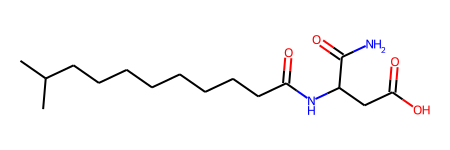

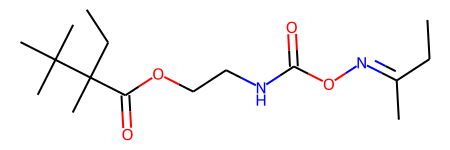

CC1=C2COC(=O)C2=C(C3=C1OC4(CC(C56C(C4C3)(CCC(O5)(OC6(C)CO)OC)C)O)C)OC
COc1c2c(c(C)c3c1C(=O)OC3)OC1(C)CC(O)C34OC(OC)(CC(O)C3(C)C1C2)OC4(C)C
0.6666666666666666


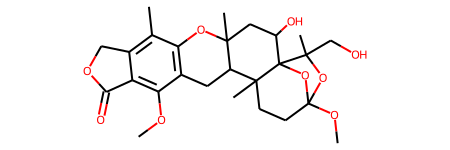

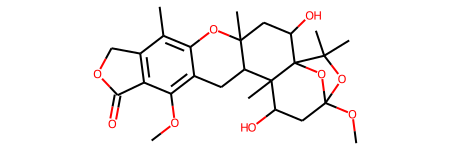

CN1C=NC=C1C(C2=CC=C(C=C2)Cl)(C3=CC4=C(C=C3)N(C(=O)C=C4C5=CC(=CC=C5)Cl)C)N
Cc1ccc(C(O)(c2cc(C)c3nc(Cl)c(-c4ccccc4)c(Cl)c3c2)c2cnc(C)[nH]2)cn1
0.18478260869565216


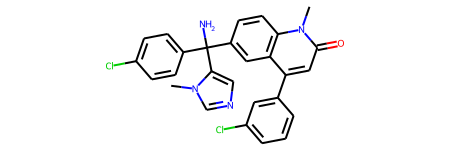

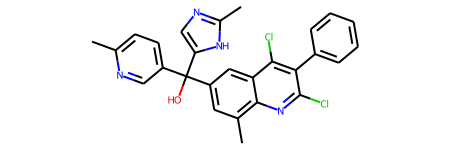

In [46]:

# Set seed
np.random.seed(0)
k=3
inds_iceberg = res_dict['ICEBERG']['individuals']

# Get k random examples
random_inds = np.random.choice(inds_iceberg, k)

# For each, display top_smiles vs. true_smiles and print their sim
for i in random_inds:
    # print obth smis
    print(i['true_smiles'])
    print(i['top_smiles'])

    print(i['true_to_top_tani_sim'])
    display(Chem.MolFromSmiles(i['true_smiles']))
    display(Chem.MolFromSmiles(i['top_smiles']))

0.5384615384615384


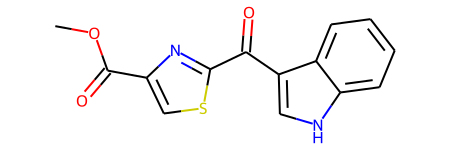

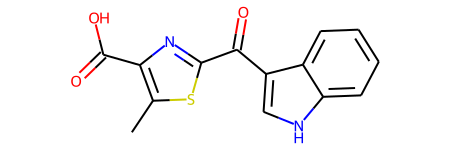

0.5384615384615384
0.8524271844660194


In [20]:
# Debug tani similarity
# Conclusion is that morgan fps underestimate similarity vs. rdkit fingerprints
s1 = "COc1cc(CCc2ccc(O)cc2)cc(OC)c1O"
s2 = "COC1=CC(=CC(=C1OC)O)CCC2=CC(=CC=C2)O"

s1 = "COC(=O)C1=CSC(=N1)C(=O)C2=CNC3=CC=CC=C32"
s2 = "Cc1sc(C(=O)c2c[nH]c3ccccc23)nc1C(=O)O"

# Compute sim
print(compute_tanimoto(s1, s2))
# Display both mols
m1 = Chem.MolFromSmiles(s1, )
m2 = Chem.MolFromSmiles(s2, sanitize=False)

m1 = Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(s1), isomericSmiles=True))
m2 = Chem.MolFromSmiles(Chem.MolToSmiles(Chem.MolFromSmiles(s2), isomericSmiles=True))

# Kekulize
# Chem.Kekulize(m1)
# Chem.Kekulize(m2)


display(m1)
display(m2)

# Show both morgan fps
fp1 = AllChem.GetMorganFingerprintAsBitVect(m1, 2)
fp2 = AllChem.GetMorganFingerprintAsBitVect(m2, 2)

# Compute tani
print(DataStructs.TanimotoSimilarity(fp1, fp2))

# Use rdkit fingerprint
fp1 = Chem.RDKFingerprint(m1)
fp2 = Chem.RDKFingerprint(m2)

# Compute tani
print(DataStructs.TanimotoSimilarity(fp1, fp2))

## Randomly showcase examples

In [54]:
# Convert to 
mgf_raw = f"../data/spec_datasets/casmi22/orig_data/CASMI_processed.mgf"
labels_df = pd.read_csv(f"../data/spec_datasets/casmi22/labels.tsv", sep="\t")
feat_to_ion = dict(labels_df[["spec", "ionization"]].values)
feat_to_ion_mass = {str(k): common.ion2mass[v] for k,v in feat_to_ion.items()}

def norm_procedure(input_spec, adduct_shift):
    
    # Shift by adduct
    new_spec = np.array([(m-adduct_shift, i) for m,i in input_spec])
    # new_spec = np.array([(m, i) for m,i in input_spec])

    x1 = common.max_inten_spec(new_spec, max_num_inten=50)
    x2 = common.bin_spectra ([x1],)
    x3 = common.norm_spectrum(x2).max(0)
    
    return x3

bins = np.linspace(0, 15000, 15000)

parsed_mgf = common.parse_spectra_mgf(mgf_raw)
parsed_mgf_res = {str(i[0]['FEATURE_ID']): 
                  {"meta": i[0], "spec": i[1][0][1], 
                  "normed_spec": norm_procedure(i[1][0][1], 
                            adduct_shift=feat_to_ion_mass[i[0]['FEATURE_ID']])
                  } for i in parsed_mgf if i[0]['FEATURE_ID'] in feat_to_ion_mass}
print(len(parsed_mgf_res))

608it [00:00, 11060.57it/s]

303


/tmp/ipykernel_786122/1631743063.py:56: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels([abs(i) for i in ax.get_yticks()])
No handles with labels found to put in legend.


71
399


No handles with labels found to put in legend.
No handles with labels found to put in legend.


137


No handles with labels found to put in legend.


428


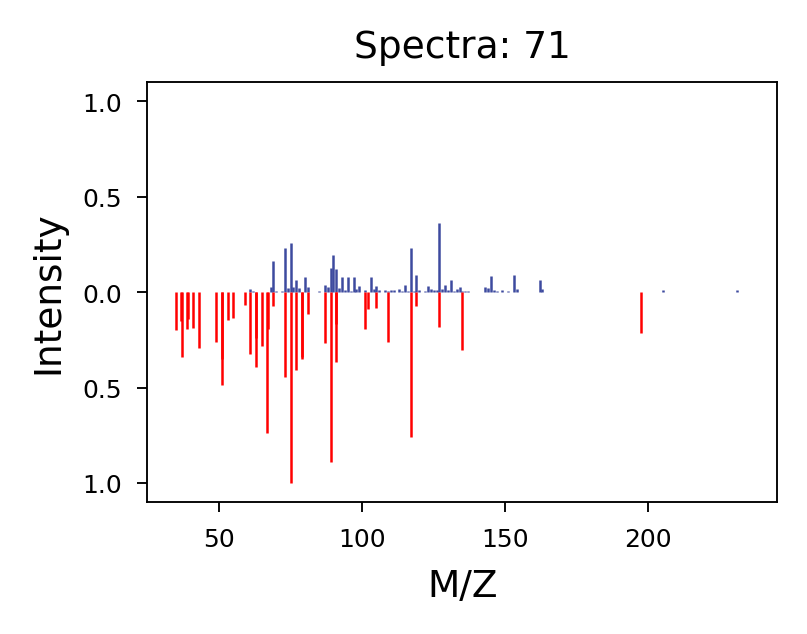

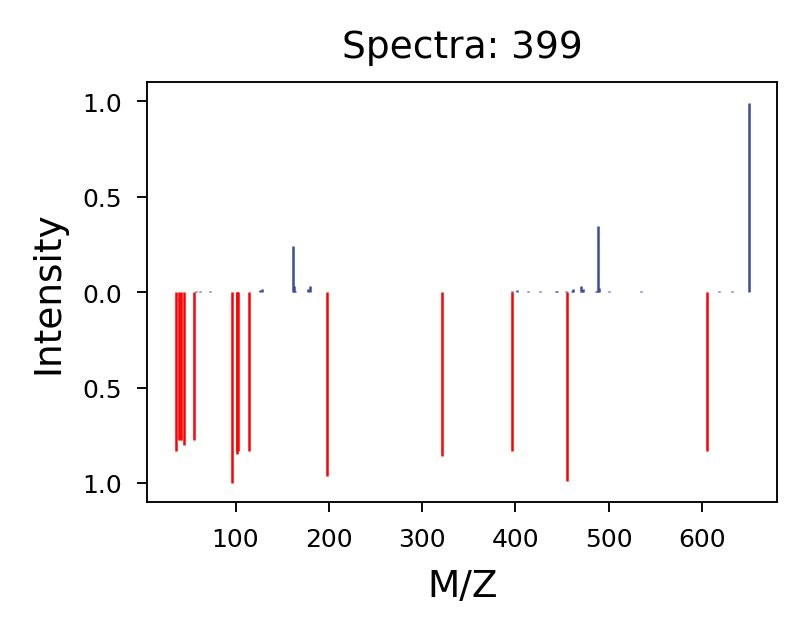

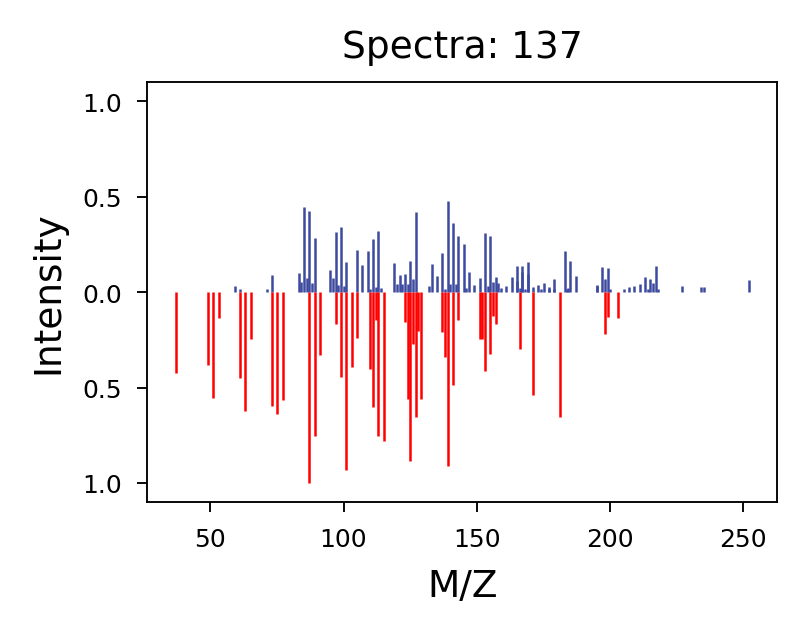

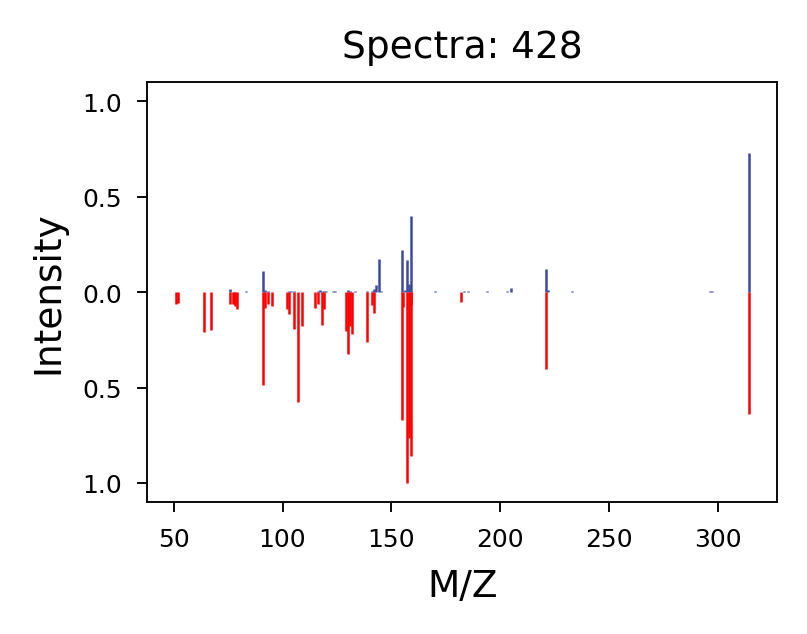

In [56]:
res_file = "../results/dag_inten_canopus_train_public/split_1_rnd1/cross_dataset/casmi22/preds_export_canopus_train_public/binned_preds.p"
# Define outfolder
out_folder = res_folder / "iceberg_canopus_pred_image_exports"
out_folder.mkdir(exist_ok=True, parents=True)
figsize = (2.1, 1.4)

# load in 
preds = pickle.load(open(res_file, "rb"))
#dict_keys(['smiles', 'ikeys', 'spec_names', 'num_bins', 'upper_limit', 'sparse_out', 'preds'])
# get len of spec names and randomly sample 10
spec_names = preds['spec_names']
np.random.seed(1)
sample_inds = np.random.choice(len(spec_names), 4)

sample_names = [str(spec_names[i]) for i in sample_inds]

for sample_ind in sample_inds:
    smiles = preds['smiles'][sample_ind]
    ikeys = preds['ikeys'][sample_ind]
    spec_name = str(preds['spec_names'][sample_ind])
    num_bins = preds['num_bins']
    upper_limit = preds['upper_limit']
    bins = np.linspace(0, upper_limit, num_bins)
    sparse_out = preds['sparse_out']
    pred = preds['preds'][sample_ind]
    print(spec_name)
    # Export mol
    mol = Chem.MolFromSmiles(smiles)
    export_mol(mol, out_folder / f"{spec_name}_mol.pdf", width=500, height=500)

    normed_spec = parsed_mgf_res[spec_name]['normed_spec']
    fig = plt.figure(figsize=figsize, dpi=300)
    ax = fig.gca()
    for x in pred:
        ax.vlines(
            x=bins[int(x[0])],
            ymin=0,
            ymax=x[1],
            color=method_colors.get("ICEBERG"),
            linewidth=0.6,
        )
    for ind, x in enumerate(normed_spec):
        if x > 0:
            ax.vlines(
                x=bins[ind],
                ymin=0,
                ymax=-x,
                color="red",
                linewidth=0.6,
            )
    ax.set_xlabel("M/Z")
    ax.set_ylabel("Intensity")
    ax.set_title(f"Spectra: {spec_name}")
    ax.set_ylim([-1.1, 1.1])
    # Set y ticks to be absolute values
    ax.set_yticklabels([abs(i) for i in ax.get_yticks()])
    
    ax.legend(**legend_params, loc="upper left")
    set_size(*figsize, ax)

    fig.savefig(
        out_folder / f"{spec_name}_pred_spec.pdf",
        dpi=300,
        bbox_inches="tight",
        transparent=True,
    )

# Get pred spec